# ĐỒ ÁN CUỐI KÌ MÔN NHẬP MÔN KHOA HỌC DỮ LIỆU


### Giảng viên hướng dần: Thầy Trần Trung Kiên
### Thành viên thực hiện
- 18120529: Phan Văn Võ Quyền
- 18120540: Phạm Minh Sỹ

## Import

In [1]:
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Thu thập dữ liệu

Dữ liệu về phân tích thành phần dinh dưỡng trong thức ăn trên trang wed  của USDA

Việc truy cập vào API không bị giới hạn nhưng người dùng cần phải đăng ký key để có thể đăng nhập

Link API document: https://fdc.nal.usda.gov/api-guide.html

In [2]:
all_data = []
max_page_number = 100
page = 1
api_key = 'sfU1TsyAobqAYE5pyGO1Jbhg1GR5kjnVz2HObgVK'
while page <= max_page_number:
    url = f'https://api.nal.usda.gov/fdc/v1/foods/list?api_key={api_key}&pageSize=100&pageNumber={page}'
    response = requests.get(url)
    data  = response.json()
    all_data.extend(data)
    #print(page)
    page += 1
    
data_set = pd.DataFrame(all_data)
data_set.to_json('data.json')

## Khám phá dữ liệu( đủ để xác định câu hỏi)

### Đọc dữ liệu từ file

In [3]:
df = pd.read_json('data.json')

In [4]:
pd.set_option('display.max_colwidth', 250)
df.head(20)

,fdcId,description,dataType,publicationDate,foodCode,foodNutrients,ndbNumber
0,1104067,100 GRAND Bar,Survey (FNDDS),2020-10-30,91715300.0,"[{'number': '203', 'name': 'Protein', 'amount': 2.5, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 19.3, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 71.0, 'unitName': 'G'}, {'n...",NaN
1,1104086,3 MUSKETEERS Bar,Survey (FNDDS),2020-10-30,91726420.0,"[{'number': '203', 'name': 'Protein', 'amount': 2.6, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 12.8, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 77.8, 'unitName': 'G'}, {'n...",NaN
2,1104087,3 Musketeers Truffle Crisp Bar,Survey (FNDDS),2020-10-30,91726425.0,"[{'number': '203', 'name': 'Protein', 'amount': 6.41, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 28.8, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 63.2, 'unitName': 'G'}, {'...",NaN
3,1099098,"Abalone, cooked, NS as to cooking method",Survey (FNDDS),2020-10-30,26301110.0,"[{'number': '203', 'name': 'Protein', 'amount': 20.4, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 4.59, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 7.26, 'unitName': 'G'}, {'...",NaN
4,1099099,"Abalone, floured or breaded, fried",Survey (FNDDS),2020-10-30,26301140.0,"[{'number': '203', 'name': 'Protein', 'amount': 18.2, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 11.4, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 15.5, 'unitName': 'G'}, {'...",NaN
5,1099100,"Abalone, steamed or poached",Survey (FNDDS),2020-10-30,26301160.0,"[{'number': '203', 'name': 'Protein', 'amount': 34.0, 'unitName': 'G'}, {'number': '204', 'name': 'Total lipid (fat)', 'amount': 1.51, 'unitName': 'G'}, {'number': '205', 'name': 'Carbohydrate, by difference', 'amount': 12.0, 'unitName': 'G'}, {'...",NaN
6,167782,"Abiyuch, raw",SR Legacy,2019-04-01,NaN,"[{'number': '318', 'name': 'Vitamin A, IU', 'amount': 100, 'unitName': 'IU', 'derivationCode': 'A', 'derivationDescription': 'Analytical'}, {'number': '268', 'name': 'Energy', 'amount': 290, 'unitName': 'kJ', 'derivationCode': 'NC', 'derivationDe...",9427.0
7,171687,"Acerola juice, raw",SR Legacy,2019-04-01,NaN,"[{'number': '268', 'name': 'Energy', 'amount': 96.0, 'unitName': 'kJ'}, {'number': '431', 'name': 'Folic acid', 'amount': 0.0, 'unitName': 'UG', 'derivationCode': 'Z', 'derivationDescription': 'Assumed zero (Insignificant amount or not naturally ...",9002.0
8,171686,"Acerola, (west indian cherry), raw",SR Legacy,2019-04-01,NaN,"[{'number': '268', 'name': 'Energy', 'amount': 134, 'unitName': 'kJ'}, {'number': '431', 'name': 'Folic acid', 'amount': 0.0, 'unitName': 'UG', 'derivationCode': 'Z', 'derivationDescription': 'Assumed zero (Insignificant amount or not naturally o...",9001.0
9,168061,Acorn stew (Apache),SR Legacy,2019-04-01,NaN,"[{'number': '429', 'name': 'Vitamin K (Dihydrophylloquinone)', 'amount': 0.0, 'unitName': 'UG', 'derivationCode': 'A', 'derivationDescription': 'Analytical'}, {'number': '430', 'name': 'Vitamin K (phylloquinone)', 'amount': 0.0, 'unitName': 'UG',...",35182.0


### Số dòng và số cột của dữ liệu

In [5]:
df.shape

(10000, 7)

### Số dòng dữ liệu bị lặp

In [6]:
df['fdcId'].duplicated().sum()

0

## Các cột dữ liệu bị thiếu

In [7]:
df.isnull().sum()

fdcId                 0
description           0
dataType              0
publicationDate       0
foodCode           5402
foodNutrients         0
ndbNumber          4603
dtype: int64

### Ý nghĩa của mỗi dòng

Kết quả phân tích thành phần dinh dưỡng của một loại món ăn

### Ý nghĩa của mỗi cột

Mô tả chi tiết về các loại thuộc tính trong dữ liệu: https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Oct2020.pdf

+ fdcId: chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi FoodData Central (FCD)
+ ndbNumber: chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi SR Legacy foods, khác với fcdID
+ description: mô tả loại món ăn gồm: tên, đặc trưng của món ăn (cách thức nấu, màu sắc, ...)
+ dataType: thông tin loại khảo sát tiến hành
+ publicationDate: thời gian công bố dữ dữ liệu phân tích  về loại món ăn
+ foodCode:  chuỗi số duy nhất được dùng để dịnh danh các loại món ăn được qui định bởi The Food and Nutrient Database for Dietary Studies (FNDDS)
+ foodNutrients: kết quả phân tích chi tiết về thành phần dinh dưỡng

### Kiểu dữ liệu của các cột

In [8]:
df.dtypes

fdcId                int64
description         object
dataType            object
publicationDate     object
foodCode           float64
foodNutrients       object
ndbNumber          float64
dtype: object

### Nhận xét về dữ liệu
- Trong các thuộc tính, thì chỉ có thuộc tính 'foodNutrients' là có chứa thông tin hữu ích có thể khai thác được
- Các thuộc tính còn lại không ảnh hưởng đến thuộc tính 'foodNutrients' ta đang quan tâm nên chúng ta có thể thể bỏ qua các thuộc tính này

## Tiền xử lý ( Tách thuộc tính mới từ thuộc tính cũ)


Chuyển thuộc tính "foodNutrients" về các thuộc tính thành phần

In [9]:
food_nutrients_dict = {}
count = 0
keys = []

for foodNutrient in df.foodNutrients:
    for component in foodNutrient:
        nutrient_component = f"{component['name']} ({component['unitName'].lower()})"
        if nutrient_component not in food_nutrients_dict:
            keys.append(nutrient_component)
            
keys = sorted(keys, reverse = True)
for key in keys:
    food_nutrients_dict[key] = []

In [10]:
len(food_nutrients_dict) # number of new attribute extracted from 'foodNutrients'

220

In [11]:
for col in food_nutrients_dict:
    print(col)

trans-beta-Carotene (ug)
trans-Lycopene (ug)
cis-beta-Carotene (ug)
cis-Lycopene (ug)
cis-Lutein/Zeaxanthin (ug)
Zinc, Zn (mg)
Zeaxanthin (ug)
Water (g)
Vitamin K (phylloquinone) (ug)
Vitamin K (Menaquinone-4) (ug)
Vitamin K (Dihydrophylloquinone) (ug)
Vitamin E, added (mg)
Vitamin E (alpha-tocopherol) (mg)
Vitamin D3 (cholecalciferol) (ug)
Vitamin D2 (ergocalciferol) (ug)
Vitamin D (D2 + D3), International Units (iu)
Vitamin D (D2 + D3) (ug)
Vitamin C, total ascorbic acid (mg)
Vitamin B-6 (mg)
Vitamin B-12, added (ug)
Vitamin B-12 (ug)
Vitamin A, RAE (ug)
Vitamin A, IU (iu)
Valine (g)
Tyrosine (g)
Tryptophan (g)
Total lipid (fat) (g)
Total fat (NLEA) (g)
Total dietary fiber (AOAC 2011.25) (g)
Tocotrienol, gamma (mg)
Tocotrienol, delta (mg)
Tocotrienol, beta (mg)
Tocotrienol, alpha (mg)
Tocopherol, gamma (mg)
Tocopherol, delta (mg)
Tocopherol, beta (mg)
Threonine (g)
Thiamin (mg)
Theobromine (mg)
Sulfur, S (mg)
Sugars, total including NLEA (g)
Sugars, Total NLEA (g)
Sucrose (g)
Stigmas

In [12]:
for foodNutrient in df.foodNutrients:
    sub_keys = []
    for component in foodNutrient:
        nutrient_component = f"{component['name']} ({component['unitName'].lower()})"
        amount = component['amount']
        sub_keys.append(nutrient_component)
        food_nutrients_dict[nutrient_component].append(amount)
    for key in food_nutrients_dict:
        if key not in sub_keys:
            food_nutrients_dict[key].append(np.NaN)

In [13]:
nutrients_df = pd.DataFrame(food_nutrients_dict, index = df['fdcId'])

In [14]:
nutrients_df.head()

,trans-beta-Carotene (ug),trans-Lycopene (ug),cis-beta-Carotene (ug),cis-Lycopene (ug),cis-Lutein/Zeaxanthin (ug),"Zinc, Zn (mg)",Zeaxanthin (ug),Water (g),Vitamin K (phylloquinone) (ug),Vitamin K (Menaquinone-4) (ug),...,14:1 t (g),14:1 c (g),14:1 (g),14:0 (g),13:0 (g),12:1 (g),12:0 (g),11:0 (g),10:0 (g),10-Formyl folic acid (10HCOFA) (ug)
fdcId,,,,,,,,,,,,,,,,,,,,,
1104067,NaN,NaN,NaN,NaN,NaN,0.99,NaN,6.10,6.2,NaN,...,NaN,NaN,NaN,1.030,NaN,NaN,1.440,NaN,0.329,NaN
1104086,NaN,NaN,NaN,NaN,NaN,0.55,NaN,5.80,2.9,NaN,...,NaN,NaN,NaN,0.295,NaN,NaN,0.093,NaN,0.085,NaN
1104087,NaN,NaN,NaN,NaN,NaN,1.83,NaN,0.18,5.8,NaN,...,NaN,NaN,NaN,1.650,NaN,NaN,2.520,NaN,0.365,NaN
1099098,NaN,NaN,NaN,NaN,NaN,0.98,NaN,65.10,31.7,NaN,...,NaN,NaN,NaN,0.028,NaN,NaN,0.000,NaN,0.000,NaN
1099099,NaN,NaN,NaN,NaN,NaN,1.06,NaN,52.40,32.0,NaN,...,NaN,NaN,NaN,0.024,NaN,NaN,0.000,NaN,0.001,NaN


## Câu hỏi đặt ra

### Đâu là công thức dùng để tính năng lượng từ các thành phần dinh dưỡng cụ thể?
Trước tiên ta xác định:
- Input được xác định là các cột thành phần dinh dưỡng
- Output được xác định là cột năng lượng
- Dễ dàng nhận ra đây là bài toán hồi quy
- Như vậy năng lượng sẽ được tính thông qua một công thức với các hạng tử là các thành phần dinh dưỡng cụ thể

Việc tìm ra câu trả lời cho câu hỏi này có ý nghĩa:
- Từ việc biết được mức năng lượng mà mỗi loại thực phẩm mang lại, con người ta có thể chủ động trong việc điều phối khẩu phần ăn hằng ngày sao cho cân bằng giữa mức năng lượng cần nạp vào và sức khỏe của họ, đặc biệt trong bối cảnh con người ngày càng chú trọng hơn vào sức khỏe của mình. Thí dụ như một người trưởng thành trung bình cần tối thiểu 1800 calo mỗi ngày, như vậy chúng ta có thể dựa vào mức năng lượng của từng thành phần dinh dưỡng trong từng món ăn để căn chỉnh sao cho thật hợp lí
- Ngoài ra nó còn giúp các chuyên gia, nhà nghiên cứu phát triển các sản phẩm phù hợp thị hiếu sức khỏe mà vẫn đảm bảo năng lượng cung cấp cho người sử dụng cùng chi phí sản xuất

Nguồn cảm hứng của câu hỏi:
- Phải nói rằng nguồn cảm hứng của câu hỏi xuất phát từ nguồn cảm hứng chọn chủ để của nhóm em, nhóm em nhận thấy rằng tỉ lệ béo phì ở dân số các quốc gia mỗi ngày một tăng, họ luôn đặt ra câu hỏi tại sao tôi ăn ít nhưng vẫn mập. Tuy nhiên họ không biết rằng họ ăn ít về khối lương nhưng lượng calo trong thực phẩm họ ăn không hề thấp, do đó nhóm em đã đặt ra câu hỏi là đâu là công thức tính năng lượng từ các thành phân dinh dưỡng của món ăn, nhằm giúp mọi người hiểu được thực phẩm họ ăn chứa nhiều năng lượng tới đâu để có thể điều chỉnh chế độ ăn cân bằng và hợp lý

## Khám phá và tiền xử lý dữ liệu (để biết cách tách các tập)

In [15]:
nutrients_df['Energy (kcal)'].dtype

dtype('float64')

In [16]:
nutrients_df['Energy (kcal)'].isna().sum()

28

In [17]:
nutrients_df.dropna(axis=0, subset=['Energy (kcal)'], inplace=True)
nutrients_df['Energy (kcal)'].isna().sum()

0

## Tiền xử lý (tách các tập)

In [18]:
# Split dataset into 3 sub dataset: train, validation and test with ratio accordingly is 60%, 20% and 20%
X = nutrients_df.drop('Energy (kcal)', axis=1)
y = nutrients_df['Energy (kcal)']

X_train_df, X_test, y_train_sr, y_test  = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_sr, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

## Khám phá dữ liệu (tập huấn luyện)

In [19]:
for dtype in X_train.dtypes:
    print(dtype)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [20]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
X_train.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,trans-beta-Carotene (ug),trans-Lycopene (ug),cis-beta-Carotene (ug),cis-Lycopene (ug),cis-Lutein/Zeaxanthin (ug),"Zinc, Zn (mg)",Zeaxanthin (ug),Water (g),Vitamin K (phylloquinone) (ug),Vitamin K (Menaquinone-4) (ug),...,14:1 t (g),14:1 c (g),14:1 (g),14:0 (g),13:0 (g),12:1 (g),12:0 (g),11:0 (g),10:0 (g),10-Formyl folic acid (10HCOFA) (ug)
missing_ratio,99.9,99.9,99.9,99.9,99.9,2.4,99.9,0.0,18.3,96.5,...,99.900,99.700,82.100,7.2,98.100,99.900,9.3,99.700,10.50,100.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.00,NaN
lower_quartile,1.0,0.0,0.0,0.0,0.0,0.4,0.5,41.9,0.6,0.0,...,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000,0.00,NaN
median,5.0,0.0,1.0,0.0,0.0,0.9,1.0,64.4,2.2,0.1,...,0.000,0.000,0.000,0.1,0.000,0.000,0.0,0.000,0.00,NaN
upper_quartile,7.0,0.0,1.0,0.0,0.0,2.3,273.5,79.9,7.1,3.0,...,0.000,0.100,0.000,0.3,0.000,0.000,0.0,0.000,0.00,NaN
max,9.0,2.0,2.0,0.0,121.0,98.9,546.0,100.0,1640.0,33.2,...,0.005,0.299,0.737,82.6,0.025,0.001,53.4,0.013,5.59,NaN


### Nhận xét về tập dữ liệu
- Dữ liệu có quá nhiều thuộc tính (219 thuộc tính)
- Một số thuộc tính có tỉ lệ thiếu cao và một số thông số không hợp lý

## Tiền xử lý tập huấn luyện

Link Data Document: https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Oct2020.pdf

Với các cột có liên quan đến Energy (kcal), Energy chỉ được đo lường bằng kcal từ tháng 10 năm 2020 và để cho đơn giản, ta chỉ xét đến Energy (kcal) nên ta loại bỏ các cột:
- Energy (kj)
- Energy (Atwater Specific Factors) (kcal)
- Energy (Atwater General Factors) (kcal)

Với các cột có liên quan đến lipit, ta loại bỏ các cột các loại axit béo, chỉ giữ lại các cột số lượng tổng cộng axit béo cuối cùng để giảm bớt nguy cơ overfitting

Với các cột có tỉ lệ dữ liệu bị thiếu trên 25% thì được loại bỏ, các cột bị thiếu còn lại thì sử dụng phương pháp mean để điền dữ liệu bi thiếu

In [21]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self, missing_ratio_threshold=0.25):
        self.missing_ratio_threshold = missing_ratio_threshold
    
    def fit(self, X_df, y=None):
        self.dropped_cols = set(['Energy (kj)', 'Energy (Atwater Specific Factors) (kcal)', 'Energy (Atwater General Factors) (kcal)'])
        cols = X_df.columns
        total_fatty_acids = ['Fatty acids, total saturated (g)']
        for col in cols:
            
            if re.search(r'[0-9]+:[0-9]+', col) != None:
                self.dropped_cols.add(col)
                continue
            if col != 'Energy (kcal)' and col not in total_fatty_acids and X_df [f'{col}'].isnull().mean() > self.missing_ratio_threshold : 
                self.dropped_cols.add(col) 
      
        return self
    
    def transform(self, X_df, y=None):
        trans_df = X_df.drop(self.dropped_cols, axis = 1)
        return trans_df

In [22]:
process_pipeline = make_pipeline(ColDropper(missing_ratio_threshold=0.25), SimpleImputer(missing_values=np.NaN, strategy='mean'), StandardScaler())
process_pipeline

Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [23]:
X_train_processed = process_pipeline.fit_transform(X_train)

In [24]:
print(X_train_processed.shape)
process_pipeline

(5982, 45)


Pipeline(steps=[('coldropper', ColDropper()),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

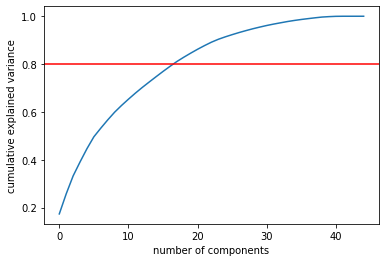

In [25]:
pca = PCA().fit(X_train_processed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.8, color='r', linestyle='-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Nhận xét: với n_components = 20 thì độ giữ lại thông tin của mô hình PCA là trên 80%

In [26]:
process_pipeline_full = make_pipeline(ColDropper(missing_ratio_threshold=0.25), SimpleImputer(missing_values=np.NaN, strategy='mean'), 
                                      StandardScaler(), PCA(n_components=20))

In [27]:
X_train_processed = process_pipeline_full.fit_transform(X_train)

In [28]:
X_train_processed.shape

(5982, 20)

## Tiền xử lý và mô hình hóa (trên tập validation)

In [29]:
X_val_processed = process_pipeline_full.transform(X_val)

## Mô hình hóa

### Tìm mô hình tốt nhất

**1. Mô hình Neural Network:**
- hidden_layer_sizes=(20), activation=‘tanh’, solver=‘lbfgs’, random_state=0, max_iter=2500
- Siêu tham số alpha của MLPRegressor với 5 giá trị khác nhau: 0.1, 1, 10, 100, 1000
- Sau khi xây dựng mô hình, tạo một full_pipeline bao gồm process_pipeline_full ở trên và mô hình

In [30]:
neural_net = MLPRegressor(hidden_layer_sizes=(20), activation='tanh',
                                 solver='lbfgs', max_iter=2500, random_state=0)
full_pipeline = make_pipeline(process_pipeline_full, neural_net)

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs_1 = []
val_errs_1 = []
alphas = [0.1, 1, 10, 100, 1000]
best_val_err = float('inf'); best_alpha = None;

for alpha in alphas:
    full_pipeline.set_params(mlpregressor__alpha=alpha)
    full_pipeline.fit(X_train, y_train)

    train_err = 1-full_pipeline.score(X_train, y_train)
    train_errs_1.append(train_err)
    val_err = 1-full_pipeline.score(X_val, y_val)
    val_errs_1.append(val_err)

    if val_err * 100 < best_val_err:
        best_val_err = val_err * 100
        best_alpha = alpha
'Finish!'

C:\Users\PC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\PC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\PC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

'Finish!'

In [31]:
full_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coldropper', ColDropper()),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=20))])),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=1000,
                              hidden_layer_sizes=20, max_iter=2500,
                              random_state=0, solver='lbfgs'))])

In [32]:
print(best_alpha)
print(best_val_err.round(3))

100
1.347


**2. Mô hình SVR (Support Vector Regressor):**
- max_iter=10 000
- Siêu tham số C của SVR  với 5 giá trị khác nhau: 1, 3, 5, 7, 9 và siêu tham số epsilon với 5 giá trị: 0.1, 0.15, 0.2, 0.25, 0.3
- Sau khi có được mô hình, tạo full_pipeline2 gồm process_pipeline_full và mô hình SVR này

In [33]:
support_vector_regression = SVR(C=1.0, epsilon=0.2, max_iter=10000)
full_pipeline2 = make_pipeline(process_pipeline_full, support_vector_regression)
train_errs_2 = []
val_errs_2 = []
Cs = [1.0, 3.0, 5.0, 7.0, 9.0]
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3]
best_val_err = float('inf'); best_c = None; best_epsilon = None;

for C in Cs:
    for epsilon in epsilons:
        full_pipeline2.set_params(svr__C = C, svr__epsilon = epsilon)
        full_pipeline2.fit(X_train, y_train)

        train_err = 1-full_pipeline2.score(X_train, y_train)
        train_errs_2.append(train_err)
        val_err = 1-full_pipeline2.score(X_val, y_val)
        val_errs_2.append(val_err)

        if val_err * 100 < best_val_err:
            best_val_err = val_err * 100
            best_c = C
            best_epsilon = epsilon
'Finish!'

'Finish!'

In [34]:
full_pipeline2

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coldropper', ColDropper()),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=20))])),
                ('svr', SVR(C=9.0, epsilon=0.3, max_iter=10000))])

In [35]:
print(best_c)
print(best_epsilon)
print(best_val_err.round(3))

9.0
0.3
8.85


**3. Mô hình RandomforestRegressor:**
- random_state=0
- Siêu tham số n_estimator của RandomForestRegressor  với 5 giá trị khác nhau: 50, 75, 100, 125, 150 và siêu tham số max_depth với 5 giá trị: 16, 32, 64, 128, 256
- Sau khi có được mô hình, tạo full_pipeline3 gồm process_pipeline_full và mô hình RandomForestRegressor

In [36]:
random_forest = RandomForestRegressor(max_depth=2, random_state=0)
full_pipeline3 = make_pipeline(process_pipeline_full, random_forest)
train_errs_3 = []
val_errs_3 = []
num_estimators = [50, 75, 100, 125, 150]
max_depths = [16, 32, 64, 128, 256]
best_val_err = float('inf'); best_num = None; best_depth = None;

for num_estimator in num_estimators:
    for max_depth in max_depths:
        full_pipeline3.set_params(randomforestregressor__n_estimators = num_estimator, randomforestregressor__max_depth = max_depth)
        full_pipeline3.fit(X_train, y_train)

        train_err = 1-full_pipeline3.score(X_train, y_train)
        train_errs_3.append(train_err)
        val_err = 1-full_pipeline3.score(X_val, y_val)
        val_errs_3.append(val_err)

        if val_err * 100 < best_val_err:
            best_val_err = val_err * 100
            best_num = num_estimator
            best_depth = max_depth
'Finish!'

'Finish!'

In [37]:
full_pipeline3

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coldropper', ColDropper()),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=20))])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=256, n_estimators=150,
                                       random_state=0))])

In [38]:
print(best_num)
print(best_depth)
print(best_val_err.round(3))

75
32
2.261


### Đánh giá kết quả trên tập validation của 3 mô hình thu được:
- Mô hình Neural Network, RandomForest cho ra kết quả khả quan, tỉ lệ đúng trên tập validation cao, trong khi đó mô hình SVR lại không cho kết quả tốt bằng 2 mô hình trên
- Việc lựa chọn giữa 2 mô hình Neural Network và RandomForest lúc này mang ý nghĩa hơi chủ quan vì nó còn phụ thuộc vào siêu tham số ta chọn, đồng thời kết quả hai mô hình đều tốt
- Cuối cùng nhóm lựa chọn mô hình Neural Network, trực quan hóa kết quả thu được trên train và validation trước, sau đó đem đi thực nghiệm trên tập test và sau đây là kết quả thu được:

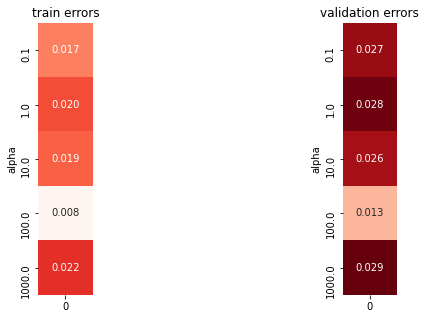

In [39]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs_1).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs_1).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs_1), min(val_errs_1))
max_err = max(max(train_errs_1), max(val_errs_1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train errors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation errors'); plt.ylabel('alpha');

In [40]:
# Chạy fit trên tập X_train_df, tập này chính là X_train + X_val ở trên, thực hiện dự đoán trên X_test
full_pipeline.set_params(mlpregressor__alpha=best_alpha)
full_pipeline.fit(X_train_df, y_train_sr)
preds = full_pipeline.predict(X_train_df).round(3)
preds = pd.DataFrame(preds)
print(preds)

            0
0     119.070
1     113.418
2     380.400
3     222.047
4      30.594
...       ...
7972   15.954
7973   16.824
7974  160.817
7975  199.624
7976   74.699

[7977 rows x 1 columns]


C:\Users\PC\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [41]:
# Tính kết quả độ chính xác của mô hình trên tập y_test
results = full_pipeline.score(X_test, y_test)
results.round(3)

0.978

## Nhìn lại quá trình làm đồ án
- Khó khăn:
    - Khó khăn trong việc đi tìm nguồn dữ liệu chính thống với thông tin chính xác, ít nhiễu, ít thô
    - Khó khăn trong việc tìm hiểu các siêu tham số của các mô hình được chọn để test
    - Khá gấp rút làm đồ án vì vướng trong thời gian thi cử
    - Khó khăn trong việc tìm hiểu về knowledge domain của dữ liệu
    - Khó khăn trong việc tiền xử lý dữ liệu
- Những điều hữu ích học được:
    - Kĩ năng khám phá và tiền xử lý dữ liệu
    - Được làm việc hoàn chỉnh trên một mô hình khoa học dữ liệu
    - Kĩ năng đọc và tìm hiểu dữ liệu, cũng như nghiên cứu các mô hình
- Nếu có thêm thời gian chúng em sẽ:
    - Dành thời gian nghiên cứu nhiều hơn về siêu tham số trong các mô hình, xem thử có thể tối ưu hơn nữa hay không
    - Chuẩn bị slide báo cáo hoàn chỉnh hơn, tìm hiểu github kĩ hơn
    - Tìm hiểu knowledge domain kĩ hơn
    - Tiền xử lý dữ liệu để dữ liệu sạch và chuẩn hơn

## Tài liệu tham khảo
- 1. sklearn.ensemble.RandomForestRegressor — scikit-learn 0.24.0 documentation (scikit-learn.org)
- 2. sklearn.svm.SVR — scikit-learn 0.24.0 documentation (scikit-learn.org)
- 3. FoodData Central (usda.gov)
- 4. Composition of Foods (usda.gov)


## The end
### Chúng em xin chân thành cảm ơn thầy ạ ^^